In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
SCALER = 'MINMAX'
LAST_N = -30

In [3]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [4]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5334,2024-05-10,5222.680176,1365.400024,2367.300049,2727.629883,2727.209961
5335,2024-05-13,5221.419922,1370.109985,2336.100098,2727.209961,2730.340088
5336,2024-05-14,5246.680176,1363.790039,2353.399902,2730.340088,2753.000000
5337,2024-05-15,5308.149902,1362.550049,2388.699951,2730.340088,2753.000000
5338,2024-05-16,5308.149902,1362.550049,2387.100098,2753.000000,2753.000000


In [5]:
# df = df.drop('Date', axis=1)
df_1 = df.iloc[:LAST_N, :].copy()
df_1 = df_1.drop('Date', axis=1)
print(df_1.tail())
train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_1.columns.values
print(col_names)

              S&P     currency         gold        kospi  kospi_shift
5304  5254.350098  1349.800049  2217.399902  2746.629883  2747.860107
5305  5243.770020  1345.310059  2236.500000  2747.860107  2753.159912
5306  5205.810059  1355.530029  2261.000000  2753.159912  2706.969971
5307  5211.490234  1350.729980  2294.399902  2706.969971  2742.000000
5308  5147.209961  1344.839966  2288.800049  2742.000000  2714.209961
['S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [6]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[:-1]:
    scale_params[i] = [train_x[i].mean(), train_x[i].var(), train_x[i].max(), train_x[i].min()]
scale_params

,S&P,currency,gold,kospi
mean,2.176281e+03,1130.407258,1246.954499,1937.711622
var,1.273183e+06,12350.214028,214029.643298,291908.008761
max,5.254350e+03,1571.400024,2294.399902,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027


In [7]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi
1990,0.137382,0.251957,0.639352,0.545668
2977,0.312446,0.257288,0.434987,0.550367
3253,0.297851,0.438384,0.458116,0.474621
4547,0.762603,0.347923,0.734163,0.938955
2100,0.115518,0.394059,0.635341,0.408931


In [8]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)
model_list = [xgb, lgbm, rf]

In [9]:
# XGB
param_xgb = {"max_depth": [10, 30, 50],
              "min_child_weight" : [1, 3, 6, 10],
              "n_estimators": [100, 200, 300, 500, 1000]
              }    
# LGB                        
param_lgbm = {"learning_rate" : [0.01, 0.1, 0.2, 0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100, 300, 500, 1000],
             "n_estimators" : [100, 200, 300, 500, 1000],
             "learning_rate" : [0.01, 0.1, 0.2, 0.5]
              }
params_rf = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
params_list = [param_xgb, param_lgbm, params_rf]

In [10]:
# grid_result = pd.DataFrame(columns=['xgb', 'lgbm', 'rf'], index=['params', 'best'])

# for i in range(len(model_list)):
#     grid_model = GridSearchCV(estimator=model_list[i], param_grid=params_list[i], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
#     grid_model.fit(train_x, train_y)
#     # grid_result.iloc[0, i] = grid_model.best_params_
#     # grid_result.iloc[1, i] = grid_model.best_score_
#     print(grid_model.best_params_)
#     print(grid_model.best_score_)

# grid_result

In [11]:
rf = RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=16, min_samples_split=8, random_state=99)
rf.fit(train_data, train_y)
pred = rf.predict(test_data)

result = mean_squared_error(test_y, pred)
result

528.294560773137

kospi       0.999831
S&P         0.000063
currency    0.000059
gold        0.000048
dtype: float64


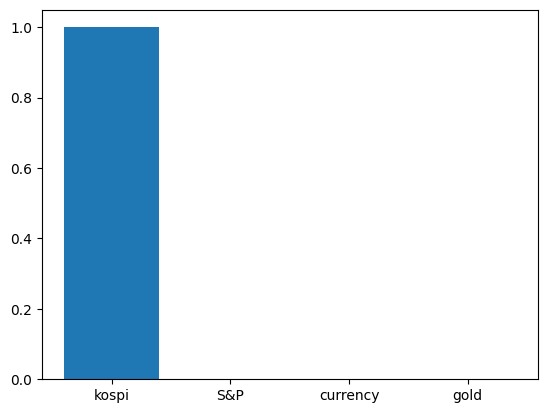

In [12]:
rf_importances = pd.Series(rf.feature_importances_, index = train_x.columns)
plt.bar(rf_importances.sort_values(ascending=False).index, rf_importances.sort_values(ascending=False))
print(rf_importances.sort_values(ascending=False))
plt.show()

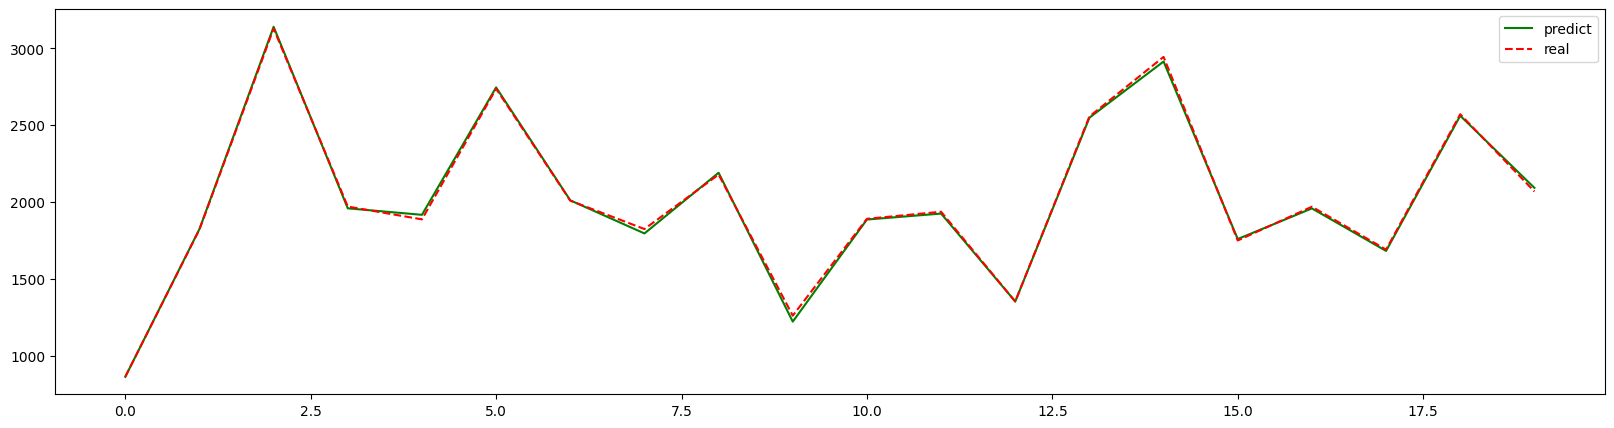

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(pred[-50:-30], 'g-', label='predict')
plt.plot(test_y[-50:-30].values, 'r--', label='real')
plt.legend()
plt.show()

In [14]:
# recent untested data prediction
for i in col_names[:-1]:
    input = df.iloc[LAST_N:, 1:].drop('kospi_shift', axis=1).apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
pred_last = rf.predict(input)
df_pred = pd.DataFrame(columns=['y', 'pred', 'diff'])
df_pred['pred'] = pred_last
df_pred['y'] = df.iloc[LAST_N:, -1:].values
df_pred['diff'] = df_pred['y'] - df_pred['pred']
df_pred

,y,pred,diff
0,2717.649902,2708.704853,8.945049
1,2705.159912,2708.704853,-3.544941
2,2706.959961,2705.577114,1.382847
3,2706.959961,2705.577114,1.382847
4,2681.820068,2706.734026,-24.913957
5,2670.429932,2685.714523,-15.284592
6,2609.629883,2684.010519,-74.380636
7,2584.179932,2616.850313,-32.670381
8,2634.699951,2580.675221,54.024731
9,2591.860107,2642.227364,-50.367256


In [15]:
df.iloc[LAST_N:, 0:1].values.reshape(-1)

array(['2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10',
       '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16',
       '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
       '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
       '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02',
       '2024-05-03', '2024-05-06', '2024-05-07', '2024-05-08',
       '2024-05-09', '2024-05-10', '2024-05-13', '2024-05-14',
       '2024-05-15', '2024-05-16'], dtype=object)

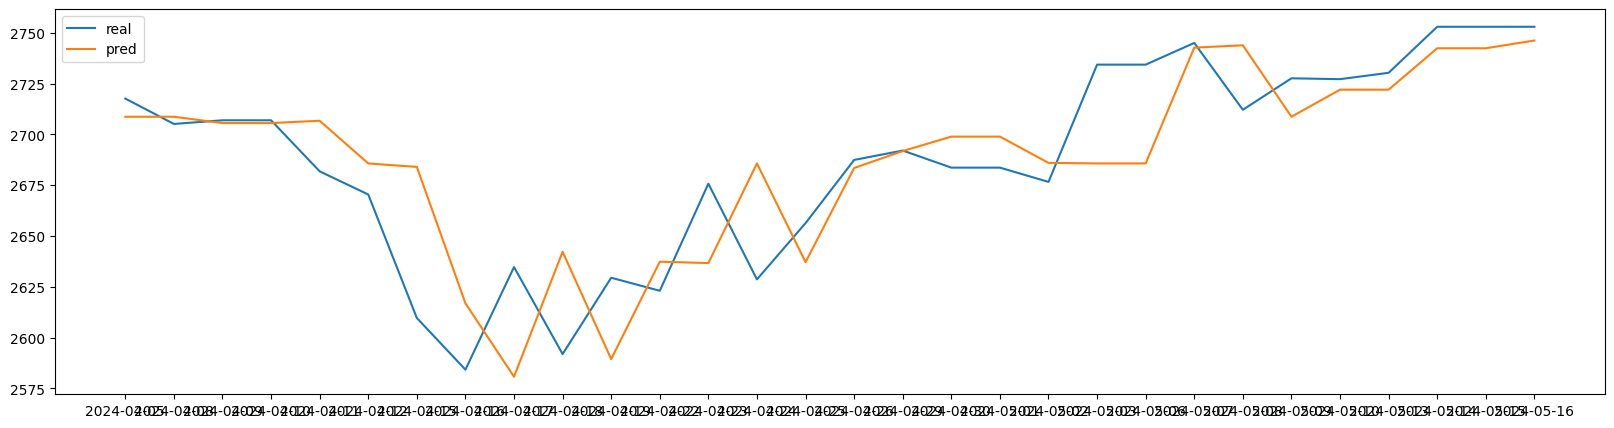

In [16]:
# recent untested data prediction
plt.figure(figsize=(20, 5))
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['y'], label='real')
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['pred'], label='pred')
plt.legend()
plt.show()

In [17]:
df_test_result = pd.merge(test_y, df['Date'], left_index=True, right_index=True, how='left')
df_test_result['pred'] = pred
df_test_result = df_test_result[['Date', 'pred', 'kospi_shift']]
df_test_result['diff'] = df_test_result['pred'] - df_test_result['kospi_shift']
df_test_result = df_test_result.sort_index(ascending=True)
df_test_result

,Date,pred,kospi_shift,diff
4,2003-12-05,794.315022,784.799988,9.515035
14,2003-12-19,814.161276,804.539978,9.621298
44,2004-01-30,855.456961,854.890015,0.566946
45,2004-02-02,856.054785,839.869995,16.184790
46,2004-02-03,848.729660,835.500000,13.229660
...,...,...,...,...
5292,2024-03-13,2687.653080,2718.760010,-31.106929
5294,2024-03-15,2665.874368,2685.840088,-19.965720
5299,2024-03-22,2745.990578,2737.570068,8.420509
5302,2024-03-27,2745.990578,2745.820068,0.170509


In [18]:
(np.square(df_test_result['diff']).sum()/len(df_test_result))**0.5

22.984659248575714

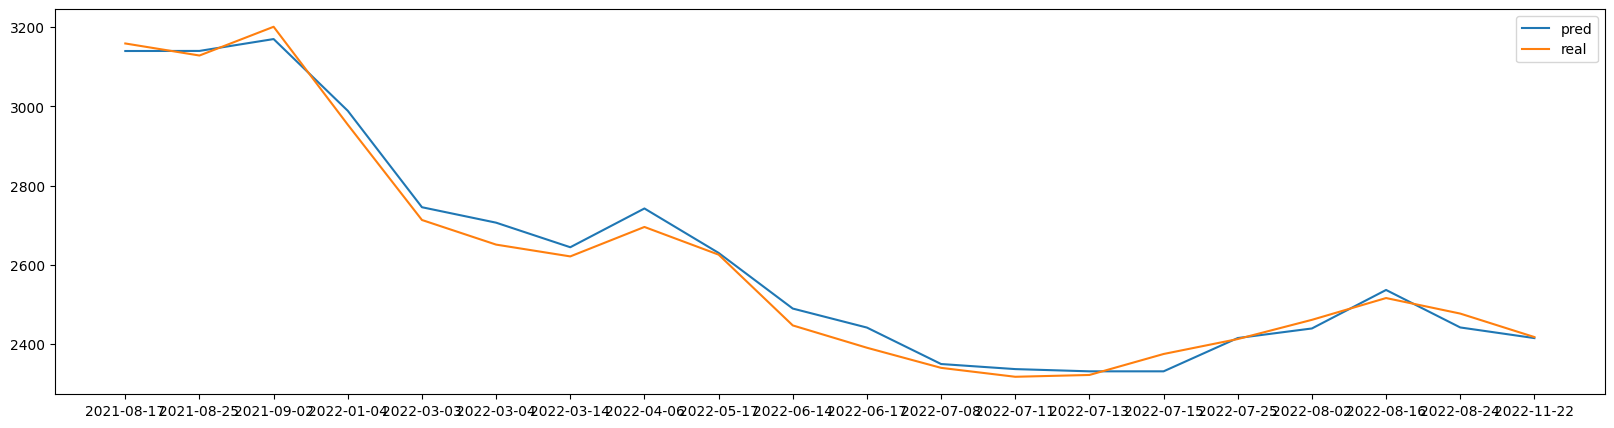

In [19]:
start = -60
end = -40
plt.figure(figsize=(20, 5))
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 1:2].values, label='pred')
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 2:3].values, label='real')
plt.legend()
plt.show()

In [20]:
mse = mean_squared_error(df_test_result['kospi_shift'], df_test_result['pred'])
mape = mean_absolute_percentage_error(df_test_result['kospi_shift'], df_test_result['pred'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 528.2946, MAPE: 0.0089
